# Deep Learning: Ex.6 - **Transfer Learning**


In [ ]:
# TensorFlow 
import tensorflow as tf
# (import more modules if needed)
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Flatten,Conv2D,MaxPooling2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip,RandomRotation
# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)

2.5.0


---
### loading the dataset


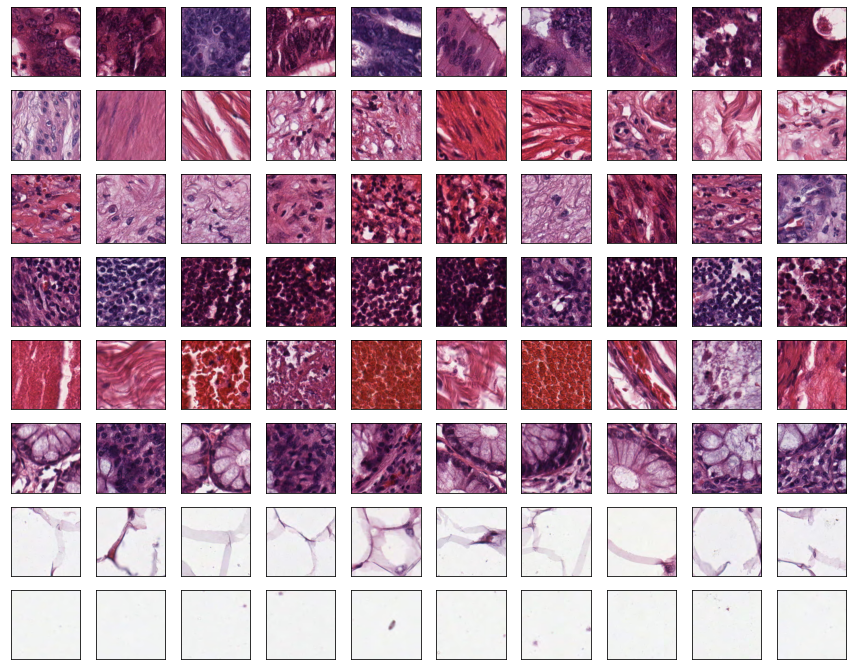

In [ ]:
import tensorflow_datasets as tfds

# fetching dataset could take ~5min..

(train_data, train_labels), (test_data, test_labels)  =  tfds.as_numpy(tfds.load(
    'colorectal_histology',
    split=['train[:90%]', 'train[90%:]'], # 4500 images for train set and 500 images for test set
    batch_size=-1,
    shuffle_files=True, 
    as_supervised=True
))


train_data = train_data.astype('float32') / 255.0
train_labels = train_labels.flatten()

test_data = test_data.astype('float32') / 255.0
test_labels = test_labels.flatten()

plt.figure(figsize=(15,12))
for c in range(8):
    [idx] = np.where(train_labels == c) 
    for i in range(10):
        plt.subplot(8,10,c*10+i+1)
        plt.imshow(train_data[idx[i]])
        plt.xticks([]), plt.yticks([])

---
### 1. Train your own ConvNet model

Build and train the following ConvNet model:

- 32 3x3-`Conv2D` + 2x2 `MaxPooling` + `Dropout(0.2)`
- 64 3x3-`Conv2D` + 2x2 `MaxPooling` + `Dropout(0.2)`
- 128 3x3-`Conv2D` + 2x2 `MaxPooling` + `Dropout(0.2)`
- `Faltten` + `Dense(8)`

Use `padding='same'` in the Conv2D layers.

Train 50 epochs (use `Adam` as optimizer) with a batch size of 64, and plot the usual graphs.


Model: "ConvNet_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 150, 150, 3)]     0         
_________________________________________________________________
First_Layer (Conv2D)         (None, 150, 150, 32)      896       
_________________________________________________________________
3x3_MaxPool1 (MaxPooling2D)  (None, 75, 75, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 75, 75, 32)        0         
_________________________________________________________________
Second_Layer (Conv2D)        (None, 75, 75, 64)        18496     
_________________________________________________________________
3x3_MaxPool2 (MaxPooling2D)  (None, 37, 37, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 37, 37, 64)      

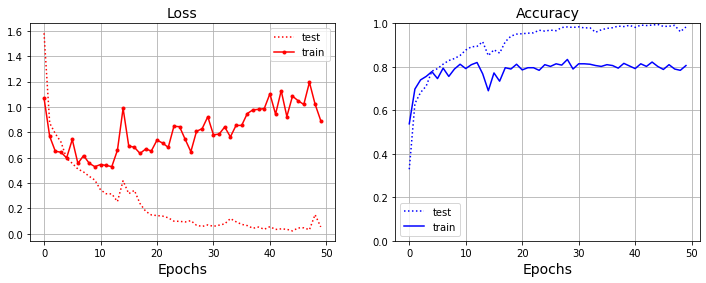

In [ ]:
inputs = tf.keras.Input(shape=(150,150,3), name='input')
x = Conv2D(32,3, padding='same', name='First_Layer',activation="relu")(inputs)
x = MaxPooling2D((2,2), name='3x3_MaxPool1')(x)
x = Dropout(rate=0.2)(x)
x = Conv2D(64,3, padding='same', name='Second_Layer',activation="relu")(x)
x = MaxPooling2D((2,2), name='3x3_MaxPool2')(x)
x = Dropout(rate=0.2)(x)
x = Conv2D(128,3, padding='same', name='Third_Layer',activation="relu")(x)
x = MaxPooling2D((2,2), name='3x3_MaxPool3')(x)
x = Dropout(rate=0.2)(x)
x = Flatten()(x)
outputs = Dense(8, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs,name = "ConvNet_Model")
model.summary()
model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy'
             ,metrics=['accuracy'])
history = model.fit(train_data, train_labels, epochs=50, batch_size=64
                   , verbose=0, validation_data=(test_data, test_labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'],':r')
plt.plot(history.history['val_loss'],'.-r')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'],':b')
plt.plot(history.history['val_accuracy'],'b')
plt.ylim([0, 1])
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

***
### 2a. Use a pretrained VGG16 model

Load the pre-trained VGG16 model without its "classifier top".

- Create a new model
- add the VGG16 (without its "top") as the new model's first layer
- freeze the weights in the first layer (of the new model (= the pre-trained VGG16 model)
- add a new "top": `Flatten`,+ `Dense(8)` 
- print the model summary
- how many trainable parameters you have?

In [ ]:
vgg16 = tf.keras.applications.VGG16(input_shape=(150,150,3),include_top=False, weights='imagenet')
vgg16.trainable = False

vgg16_model = Sequential()
vgg16_model.add(vgg16)
vgg16_model.add(Flatten())
vgg16_model.add(Dense(8, activation='softmax'))
vgg16_model.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 65544     
Total params: 14,780,232
Trainable params: 65,544
Non-trainable params: 14,714,688
_________________________________________________________________


***
### 2b. Transfer learning

We will try the weight of the new "top":

Train the new model (with the frozen VGG layers) for 30 epochs and plot the usual graphs.

(Did you get better results?)

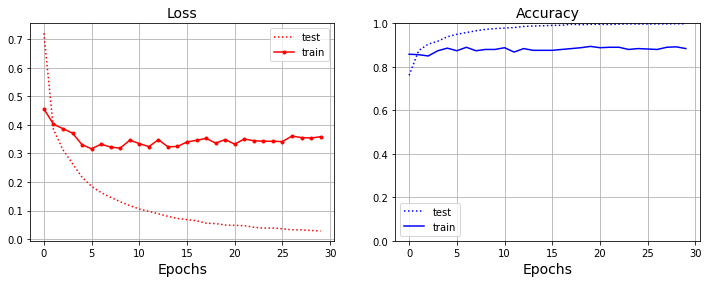

In [ ]:
vgg16_model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy'
             ,metrics=['accuracy'])
vgg16_history = vgg16_model.fit(train_data, train_labels, epochs=30, batch_size=64
                   , verbose=0, validation_data=(test_data, test_labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(vgg16_history.history['loss'],':r')
plt.plot(vgg16_history.history['val_loss'],'.-r')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

plt.subplot(1,2,2)
plt.plot(vgg16_history.history['accuracy'],':b')
plt.plot(vgg16_history.history['val_accuracy'],'b')
plt.ylim([0, 1])
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

***
### 2c. Fine tuning

At this point, you can 'unfreeze' the VGG layers and continue the training process (with slower learning rate) to get better results.

Train the unfrozen model for 20 more epochs.

- use: `Adam(learning_rate=0.00001)` 

Remember to recompile your model, in order to the changes to take effect.

(Did you get better results?)

Plot the usual graphs, **but** this time add together the new 20 epochs (from 2c) to the previous 30 epochs (from 2b). See the last slide from the lecture.

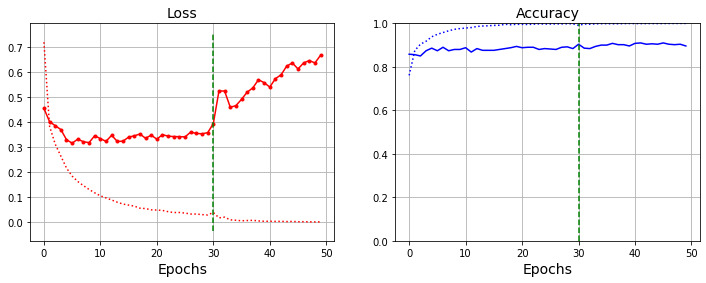

In [ ]:
vgg16_model.layers[0].trainable = True

my_opt = keras.optimizers.Adam(learning_rate=0.00001)

vgg16_model.compile(optimizer= my_opt, loss='sparse_categorical_crossentropy'
             ,metrics=['accuracy'])

vgg16_history2 = vgg16_model.fit(train_data, train_labels, epochs=20, batch_size=64
                   , verbose=0, validation_data=(test_data, test_labels))


loss = vgg16_history.history['loss'] + vgg16_history2.history['loss']
accuracy = vgg16_history.history['accuracy'] + vgg16_history2.history['accuracy']
val_loss = vgg16_history.history['val_loss'] + vgg16_history2.history['val_loss']
val_accuracy = vgg16_history.history['val_accuracy'] + vgg16_history2.history['val_accuracy']


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss,':r')
plt.plot(val_loss,'.-r')
plt.plot([30,30], plt.ylim(),'--g')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy,':b')
plt.plot(val_accuracy,'b')
plt.ylim([0, 1])
plt.plot([30,30], plt.ylim(),'--g')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

### 3a. Data augmentation

Now, we will repeat the same steps as in 2a+2b+2c, but this time we will add data-augmentation (using some preprocessing layers).

- Choose a set of preprocessing layers (RandomFlip, RandomRotation,...)
- Apply your preprocessing set on a single training image, to generate 36 new variations from it.
- Display the 36 variations using a 6x6 subplots. 


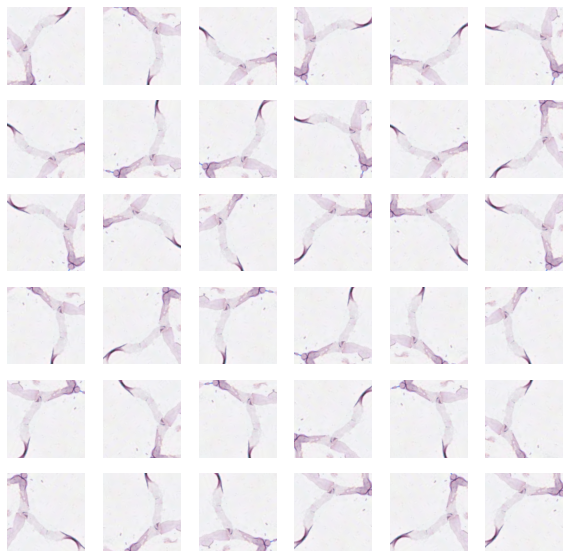

In [ ]:
data_augmentation = Sequential([
  RandomFlip("horizontal_and_vertical"),
  RandomRotation(0.2)
])
image = tf.expand_dims(train_data[0], 0)
plt.figure(figsize=(10, 10))
for i in range(36):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(6, 6, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")





### 3b. Data augmentation + Transfer learning + Fine tuning

Build a new model, starting with your preprocessing layers, then the "top-less" VGG16, and finally the new top (`Flatten`+`Dense(8)`).

Freeze the parameters of the VGG16 layer (print your model's summary to verify).

- Train 30 epochs using the frozen layers, 
- Unfreeze the layers
- Train 20 more epochs using the unfrozen layers (with slower learning rate, as before)

Plot the same graphs as in 2c.


(Did you get better results?)


In [ ]:
new_vgg16 = tf.keras.applications.VGG16(input_shape=(150,150,3),include_top=False, weights='imagenet')

new_vgg16.trainable = False

new_vgg16_model = Sequential()
new_vgg16_model.add(new_vgg16)
new_vgg16_model.add(Flatten())
new_vgg16_model.add(Dense(8, activation='softmax'))
new_vgg16_model.summary()



Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_5 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 65544     
Total params: 14,780,232
Trainable params: 65,544
Non-trainable params: 14,714,688
_________________________________________________________________


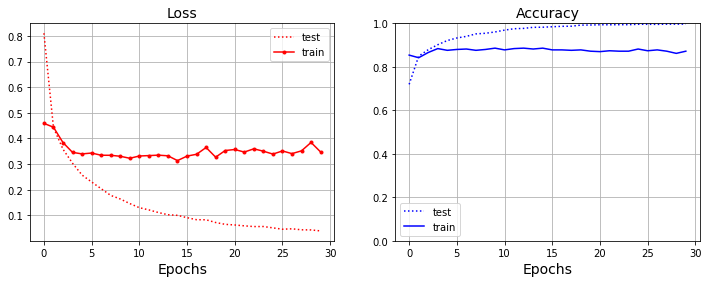

In [ ]:
augmented_images = data_augmentation(train_data)
new_vgg16_model.compile(optimizer= 'adam', loss='sparse_categorical_crossentropy'
             ,metrics=['accuracy'])
new_vgg16_history = new_vgg16_model.fit(augmented_images, train_labels, epochs=30, batch_size=64
                   , verbose=0, validation_data=(test_data, test_labels))

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(new_vgg16_history.history['loss'],':r')
plt.plot(new_vgg16_history.history['val_loss'],'.-r')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

plt.subplot(1,2,2)
plt.plot(new_vgg16_history.history['accuracy'],':b')
plt.plot(new_vgg16_history.history['val_accuracy'],'b')
plt.ylim([0, 1])
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

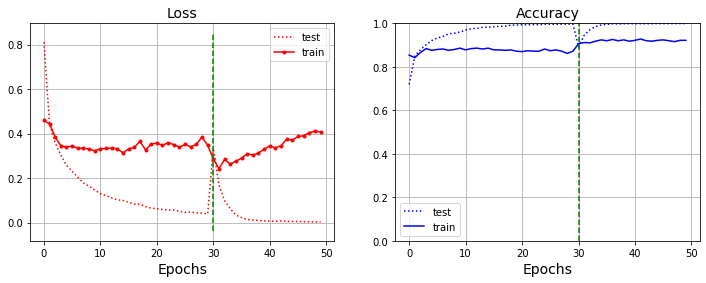

In [ ]:
new_vgg16_model.layers[0].trainable = True

my_opt = keras.optimizers.Adam(learning_rate=0.00001)

new_vgg16_model.compile(optimizer= my_opt, loss='sparse_categorical_crossentropy'
             ,metrics=['accuracy'])

new_vgg16_history2 = new_vgg16_model.fit(train_data, train_labels, epochs=20, batch_size=64
                   , verbose=0, validation_data=(test_data, test_labels))


loss = new_vgg16_history.history['loss'] + new_vgg16_history2.history['loss']
accuracy = new_vgg16_history.history['accuracy'] + new_vgg16_history2.history['accuracy']
val_loss = new_vgg16_history.history['val_loss'] + new_vgg16_history2.history['val_loss']
val_accuracy = new_vgg16_history.history['val_accuracy'] + new_vgg16_history2.history['val_accuracy']


plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(loss,':r')
plt.plot(val_loss,'.-r')
plt.plot([30,30], plt.ylim(),'--g')
plt.title('Loss',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()

plt.subplot(1,2,2)
plt.plot(accuracy,':b')
plt.plot(val_accuracy,'b')
plt.ylim([0, 1])
plt.plot([30,30], plt.ylim(),'--g')
plt.title('Accuracy',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.legend({'train','test'})
plt.grid()